<a href="https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/attention_torch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basics of differentiable (soft) attention


We show how to implement soft attention.
Based on sec 10.3 of http://d2l.ai/chapter_attention-mechanisms/attention-scoring-functions.html.



In [1]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(seed=1)
import math
import collections

import torch
from torch import nn
from torch.nn import functional as F

!mkdir figures # for saving plots

!wget https://raw.githubusercontent.com/d2l-ai/d2l-en/master/d2l/torch.py -q -O d2l.py
import d2l

# Masked soft attention

In [2]:
def masked_softmax(X, valid_lens):
    """Perform softmax operation by masking elements on the last axis."""
    # `X`: 3D tensor, `valid_lens`: 1D or 2D tensor
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = d2l.sequence_mask(X.reshape(-1, shape[-1]), valid_lens,
                              value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

Example. Batch size 2, feature size 2, sequence length 4.
The valid lengths are 2,3. So the output has size (2,2,4),
but the length dimension is full of 0s in the invalid locations.

In [7]:
Y = masked_softmax(torch.rand(2, 2, 4), torch.tensor([2, 3]))
print(Y)


tensor([[[0.5557, 0.4443, 0.0000, 0.0000],
         [0.4878, 0.5122, 0.0000, 0.0000]],

        [[0.4177, 0.3082, 0.2742, 0.0000],
         [0.3443, 0.3910, 0.2647, 0.0000]]])


Example. Batch size 2, feature size 2, sequence length 4.
The valid lengths are (1,3) for batch 1, and (2,4) for batch 2.

In [6]:
Y = masked_softmax(torch.rand(2, 2, 4), torch.tensor([[1, 3], [2, 4]]))
print(Y)

tensor([[[1.0000, 0.0000, 0.0000, 0.0000],
         [0.3079, 0.4462, 0.2459, 0.0000]],

        [[0.3109, 0.6891, 0.0000, 0.0000],
         [0.3129, 0.3470, 0.1472, 0.1930]]])


# Additive attention

$$
\alpha(q,k) = w_v^T \tanh(W_q q  + w_k k)
$$



In [9]:
class AdditiveAttention(nn.Module):
    def __init__(self, key_size, query_size, num_hiddens, dropout, **kwargs):
        super(AdditiveAttention, self).__init__(**kwargs)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=False)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=False)
        self.w_v = nn.Linear(num_hiddens, 1, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens):
        queries, keys = self.W_q(queries), self.W_k(keys)
        # After dimension expansion, shape of `queries`: (`batch_size`, no. of
        # queries, 1, `num_hiddens`) and shape of `keys`: (`batch_size`, 1,
        # no. of key-value pairs, `num_hiddens`). Sum them up with
        # broadcasting
        features = queries.unsqueeze(2) + keys.unsqueeze(1)
        features = torch.tanh(features)
        # There is only one output of `self.w_v`, so we remove the last
        # one-dimensional entry from the shape. Shape of `scores`:
        # (`batch_size`, no. of queries, no. of key-value pairs)
        scores = self.w_v(features).squeeze(-1)
        self.attention_weights = masked_softmax(scores, valid_lens)
        # Shape of `values`: (`batch_size`, no. of key-value pairs, value
        # dimension)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [10]:
# batch size 2. 1 query of dim 20, 10 keys of  dim 2.
queries, keys = torch.normal(0, 1, (2, 1, 20)), torch.ones((2, 10, 2))
# 10 values of dim 4 in each of the 2 batches.
values = torch.arange(40, dtype=torch.float32).reshape(1, 10,
                                                       4).repeat(2, 1, 1)
print(values.shape)
valid_lens = torch.tensor([2, 6])

attention = AdditiveAttention(key_size=2, query_size=20, num_hiddens=8,
                              dropout=0.1)
attention.eval()
A = attention(queries, keys, values, valid_lens)
print(A.shape)
print(A)

torch.Size([2, 10, 4])
torch.Size([2, 1, 4])
tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]], grad_fn=<BmmBackward0>)


The heatmap is uniform across the keys, since the keys are all 1s.
However, the support is truncated to the valid length.

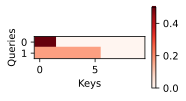

In [11]:
d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')

# Dot-product attention


$$
A = \text{softmax}(Q K^T/\sqrt{d}) V
$$


In [12]:
class DotProductAttention(nn.Module):
    """Scaled dot product attention."""
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    # Shape of `queries`: (`batch_size`, no. of queries, `d`)
    # Shape of `keys`: (`batch_size`, no. of key-value pairs, `d`)
    # Shape of `values`: (`batch_size`, no. of key-value pairs, value
    # dimension)
    # Shape of `valid_lens`: (`batch_size`,) or (`batch_size`, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Set `transpose_b=True` to swap the last two dimensions of `keys`
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        self.attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), values)

In [13]:
# batch size 2. 1 query of dim 2, 10 keys of  dim 2.
queries = torch.normal(0, 1, (2, 1, 2))
attention = DotProductAttention(dropout=0.5)
attention.eval()
attention(queries, keys, values, valid_lens)

tensor([[[ 2.0000,  3.0000,  4.0000,  5.0000]],

        [[10.0000, 11.0000, 12.0000, 13.0000]]])

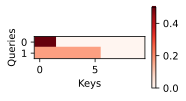

In [15]:

d2l.show_heatmaps(attention.attention_weights.reshape((1, 1, 2, 10)),
                  xlabel='Keys', ylabel='Queries')